# Running Classifiers 

The spam folder did not exist on email systems in the recent past. Emails that were relevant to the reader had to be manually (and painfully) sorted from an array of emails soliciting money or selling hoax products, among other things. The classification of our emails, by machines, into relevant emails and spam, has advanced to such a degree that we now take for granted that all the spam email we receive is automatically routed to the spam folder, needing little oversight from us. These machine classifiers use algorithms that are applicable to a wide variety of fields: written language; spoken language (e.g. "Hello Google", "Alexa", "Siri"); navigating driverless cars; and we'll also use them to understand brain activity. 

This notebook will walk you through the steps of extracting fMRI signal (from preprocessed data), and then training and testing classifiers on the brain.


## Goal of this script
Using this script you will learn to use a classifier on a dataset. Specifically, we will accomplish the following:  
>1. Assign labels to every time-point (TR) in the dataset.
>2. Time-shift the signal to be classified, taking into consideration the delayed hemodynamic response.
>3. Collect BOLD data for all runs into one array.
>4. Test out a classifier (SVM) on a group of subjects with a fixed set of parameters.
>5. Replicate the analysis that led to the modular vs. distributed processing debate.

### Pre-requisite
You should be familiar with the data loading and normalization steps in the 02-data-handling notebook.

Important terms you should be familiar with: TRs, labels.

## Table of Contents
[1. Loading and Normalization](#load_data)  
>[1.1 Experiment labels](#label_data)  
>[1.2 Plot the different conditions](#plot_boxcar)  
>[1.3 Hemodynamic lag: Time shift the labels](#label_shift)  
>[1.4 Load the fMRI data](#load_fmri)  

[2. Classification](#classification)  
>[2.1 Reshape data](#reshape)  
>[2.2 Model training](#model_training)  
>[2.3 Model testing](#model_testing)  
>[2.4 Test across participants](#across_ppts)  

[3. Modular vs Distributed Processing](#mod)
>[3.1 Prepare data](#prep)  
>[3.2 FFA](#mod_dist_ffa)  
>[3.3 PPA](#mod_dist_ppa) 

Exercises
>[Exercise 1](#ex1)  [2](#ex2)  [3](#ex3)   [4](#ex4)  [5](#ex5)   [6](#ex6)

[Novel contribution](#novel)

[Contributions](#contributions)



**Dataset** For this script we will use the localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. Just to recap: The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the MATLAB stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial. In this example, all the data have been pre-processed for you.

**Python Indexing Reminder:** Everything begins at [0], not [1].


In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim

# load some helper functions
from utils import load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data 
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run # load some constants

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [2]:
print('Here are some constants, which is specific to the VDC data:')
print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %s' % (vdc_n_runs))
print('1 TR = %.2f sec' % (vdc_TR))
print('HRF lag = %.2f sec' % (vdc_hrf_lag))
print('num TRs per run = %d' % (vdc_TRs_run))

Here are some constants, which is specific to the VDC data:
data dir = /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.50 sec
HRF lag = 4.50 sec
num TRs per run = 310


In [3]:
# Directory structure of the VDC dataset
header_file=os.path.join(vdc_data_dir,'README.txt')
!head -50 $header_file

1. Data structure

my_dataset/
├── README.txt 							# This file, Contains experimental design/task details, imaging parameters, and description of the directory structure
├── DESIGN.txt 							# Descriptions of design matrixes (in design_matrix folder)
├── sub-01/								
	├── day1								# Data of the first fMRI session (day 1)
	│   ├── anat
	│   │   ├── sub-01_fieldmap_01.nii.gz		# Field map image to correct B0 inhomogeneities 
	│   │   ├── sub-01_fieldmap_02.nii.gz
	│   │   ├── sub-01_t1_flash01.nii.gz		# Fast Low Angle shot anatomical scan
	│   │   ├── sub-01_t1_mprage.nii.gz		# raw 3-D structural image (T1-weighted magnetization prepared rapid acquisition gradient-echo image)
	│   │   ├── sub-01_t2_tse_01.nii.gz		# T2-weighted turbo spin echo image for hippocampal segmentation
	│   │   └── sub-01_t2_tse_02.nii.gz		
	│   └── func
	│       ├── sub-01_study_01.nii.gz			# Raw 4-D functional image of a study phase (run 1-6)
	│       ├── sub-01_study_02.nii.gz
	│       ├── sub-01_study

**Self-study:** the above command uses an `!` at the start of the line. What does that mean?

## 1. Loading and Normalization<a id="load_data"></a>

We will load in the vdc dataset in the same way as in the 02-data-handling notebook. First we will load and visualize the experiment labels and then we will load the brain data.

### 1.1 Experiment labels <a id="label_data"></a>

To load in the labels, you previously used a function called `load_vdc_stim_labels(subject_name)`. Here is the source code for that function: 

In [4]:
# Set the variables
sub = 'sub-01';

# Preset the variable size
stim_label = [];
stim_label_allruns = [];
for run in range(1, vdc_n_runs+1):
    
    # Specify the input variables
    in_file = os.path.join(vdc_data_dir,sub,'ses-day2','design_matrix','%s_localizer_0%d.mat' % (sub, run))
    
    # Load in data from MATLAB
    stim_label = scipy.io.loadmat(in_file);
    stim_label = np.array(stim_label['data']);

    # Store the data
    if run == 1:
        stim_label_allruns = stim_label;
    else:       
        stim_label_allruns = np.hstack((stim_label_allruns, stim_label))

print("Loaded labels for", sub)

Loaded labels for sub-01


<div class="alert alert-block alert-warning">
<strong> Usage of hstack and vstack:</strong> hstack stacks arrays in sequence horizontally (column wise) and vstack stacks arrays in sequence vertically (row wise). More details can be found at 
<a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html">np.hstack</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html">np.vstack</a>.
</div>

<div class="alert alert-block alert-info">
<strong> Recommendation: Creating and using functions is an efficient way to program. </strong>  

Although we can load the data with the set of commands above, this isn't an efficient way to code if we want to re-use this code. A better way to code is to make a **function** that performs the loading of the data and then can be called with different input variables to load in new data. We do this below.  

Functions are extremely useful for many reasons and so should be used everywhere: they allow you to remove redundancy in your code, reduce the likelihood of an error since if you update the function you update all of its uses, and make your code much more readable.  

A useful tutorial on functions is found [here](https://www.datacamp.com/community/tutorials/functions-python-tutorial).  

One important thing to be aware of is how variables are shared between your workspace and a function. If you have variables in your workspace (i.e., any variables you have created in the usage of jupyter) then they will usually be accessible/usable in a function, regardless of whether they are used as input parameters. However, any variables you create in a function cannot be used in your workspace if you don't return them as outputs. For this reason it is easier if you keep the names of the variables in your function separate from the names in your workspace. This is turtles all the way down: if you have a function within a function then variables will be shared in the same way.  

The function that we will now create is called `load_vdc_stim_labels`. You can see that this is a function since it starts with `def`. This simply re-creates the function that was previously imported from `utils.py`.  

For pedagogical purposes we have created functions in the same notebook here. In practice, functions are stored in separate files e.g. the `utils.py`, where we have stored many of our functions.
</div>

In [5]:
# Make a function for loading in the labels
def load_vdc_stim_labels(vdc_data_dir, subject_id):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1, vdc_n_runs+1):
        in_file = os.path.join(vdc_data_dir,subject_id,'ses-day2','design_matrix','%s_localizer_0%d.mat' % 
                               (subject_id, run))
        # Load in data from MATLAB
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))
    print("Loaded labels for", subject_id)
    return stim_label_concatenated

# Note: you won't see the printed "Loaded labels for..." until you run the function with inputs (see next step)

We now want to call this function and get its outputs.

In [6]:
# Load in the labels of the data
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir, sub)

Loaded labels for sub-01


We need category labels to train a classifier for every timepoint in the fMRI data. These timepoints are also referred to as TRs.

This subject has 310 TRs but all others have 311 (no good reason, just a quirk of the dataset). Some TRs will not have a label since there was no stimulus presented (e.g., the fixation periods between blocks). 

Recall that the third row of the timing file is the start time of a trial in seconds since the start of the run. We can thus convert each time stamp to a specific TR by taking that time stamp and dividing by the TR duration (1.5 s). 

In [7]:
# Preset variables
_, events = stim_label_allruns.shape
events_run = int(events / vdc_n_runs)

# Preset the array with zeros
stim_label_TR = np.zeros((vdc_TRs_run * 3, 1))

# Cycle through the runs
for run in range(vdc_n_runs):

    # Cycle through each element in a run
    for i in range(events_run):

        # What element in the concatenated timing file are we accessing
        time_idx = run * (events_run) + i

        # What is the time stamp
        time = stim_label_allruns[2, time_idx]

        # What TR does this timepoint refer to?
        TR_idx = int(time / vdc_TR) + (run * (vdc_TRs_run - 1))

        # Add the condition label to this timepoint
        stim_label_TR[TR_idx] = stim_label_allruns[0, time_idx]

print(stim_label_TR.shape)

(930, 1)


**Exercise 1:**<a id="ex1"></a> Encapsulate the code above in a function that returns a list of category labels, one for each TR in chronological order. Name this function `label2TR`. You will need the following variables: `stim_labels`, `num_runs`, `TR`, and `TRs_run`.

In [45]:
# Define the function
def label2TR(stim_labels, num_runs, TR, TRs_run):
    _, events = stim_labels.shape
    events_run = int(events / num_runs)
    for run in range(num_runs):
        for i in range(events_run):
            time_idx = run * (events_run) + i
            time = stim_labels[2, time_idx]
            TR_idx = int(time / TR) + (run + (TRs_run - 1))
            stim_label_TR[TR_idx] = stim_labels[0, time_idx]
    return(stim_label_TR)

Now run the function and check that it works

In [46]:
# Run function
stim_label_TR_b = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run)
print(stim_label_TR == stim_label_TR_b)
print(stim_label_TR.shape)

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 

### 1.2 Plot the different conditions <a id="plot_boxcar"></a>

Below we create a box car plot (looks like square waves) of the timing of different conditions for the first run. 

Text(0.5, 0, 'Time in secs')

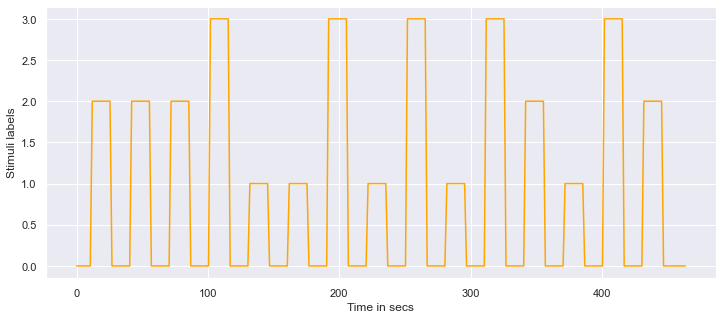

In [8]:
# Create a sequence of timepoints that a TR occurred on
time_points = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(time_points, stim_label_TR[0:vdc_TRs_run, 0], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

###  1.3 Hemodynamic lag: Time shift the labels <a id="label_shift"></a>

The BOLD response that we measure with fMRI is slow to emerge after the onset of a stimulus, also known as the "hemodynamic lag". Below we plot the expected BOLD response to a single experimental event.
More details about the hemodynamic response function (HRF) can be found [here](http://mindhive.mit.edu/node/72).

In [9]:
# To see the HRF, we will use a re-named function from fmrisim in BrainIAK
help(hrf_func)

Help on function _double_gamma_hrf in module brainiak.utils.fmrisim:

_double_gamma_hrf(response_delay=6, undershoot_delay=12, response_dispersion=0.9, undershoot_dispersion=0.9, response_scale=1, undershoot_scale=0.035, temporal_resolution=100.0)
    Create the double gamma HRF with the timecourse evoked activity.
    Default values are based on Glover, 1999 and Walvaert, Durnez,
    Moerkerke, Verdoolaege and Rosseel, 2011
    
    Parameters
    ----------
    
    response_delay : float
        How many seconds until the peak of the HRF
    
    undershoot_delay : float
        How many seconds until the trough of the HRF
    
    response_dispersion : float
        How wide is the rising peak dispersion
    
    undershoot_dispersion : float
        How wide is the undershoot dispersion
    
    response_scale : float
         How big is the response relative to the peak
    
    undershoot_scale :float
        How big is the undershoot relative to the trough
    
    scale_functi

Text(0.5, 0, 'Time in secs')

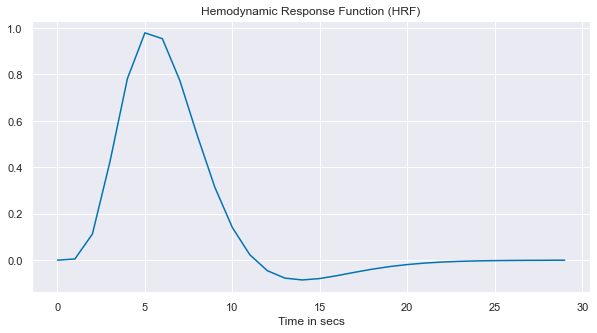

In [10]:
# Create an example HRF
hrf = hrf_func(temporal_resolution=1)

# Plot the canonical double gamma HRF
f, ax = plt.subplots(1,1, figsize = (10, 5))
ax.plot(range(30), hrf)

ax.set_title("Hemodynamic Response Function (HRF)")
ax.set_xlabel('Time in secs')

**1.3.1 Modelling the HRF**  

We now model the HRF for two different scenarios: a sequence of stimuli presented close together (block design) and individual stimuli presented far apart (event design). We can use this code to ask questions about what the (expected) neural response will look like under different experimental designs.

We need to set up a few parameters: 
> `trDuration`: how long is each TR  
> `numTRs`: total number of TRs in the experiment  
> `onsets`: timepoints in experiment when stimuli appear  
> `event_duration`: how long is each event (duration of block for block design or of a trial for event-related design)  

Let's start with the block design case, where stimuli are presented continuously for 10 s (5 TRs)

In [11]:
# Specify some parameters
trDuration = 2  # seconds
numTRs = 40 # How many TRs will you generate?
total_time = int(numTRs * trDuration)
temporal_res = 0.5 # 1/trDuration

In [12]:
# The event onsets at 20 seconds.
# The block lasts for 10 seconds (5 TRs).

stim_A = sim.generate_stimfunction(onsets=[20], 
                                   event_durations=[10], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res 
                                   )

Text(0.5, 0.98, 'Stimulus Timing: Block 10 s (5 TRs)')

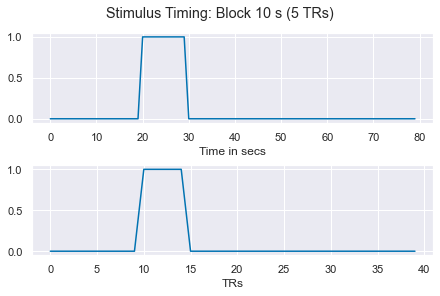

In [13]:
# Plot the design
fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=True)

ax0.plot(stim_A.repeat(trDuration))
ax0.set_xlabel('Time in secs')

ax1.plot(stim_A)
ax1.set_xlabel('TRs')

fig.suptitle('Stimulus Timing: Block 10 s (5 TRs)')

In [14]:
# Create the expected neural response
signal_func_A = sim.convolve_hrf(stimfunction=stim_A,
                                 tr_duration=trDuration,
                                 temporal_resolution=temporal_res,
                                 scale_function=1,
                                 )

Text(0.5, 0, 'TRs')

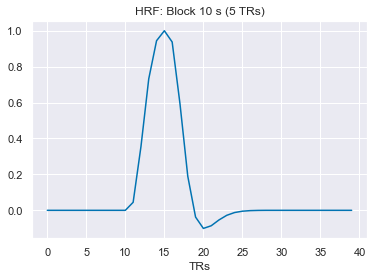

In [15]:
plt.plot(signal_func_A)
plt.title('HRF: Block 10 s (5 TRs)')
plt.xlabel('TRs')

Now we will consider what happens if two stimuli are presented for 2 s each, with 6 s in-between

In [16]:
# The events onset at 20 and 30 seconds
# Each event lasts for 2 seconds (1 TR)
stim_B = sim.generate_stimfunction(onsets=[20,28],
                                   event_durations=[2,2],
                                   total_time=total_time,
                                   temporal_resolution=temporal_res,
                                  )

Text(0.5, 0, 'TRs')

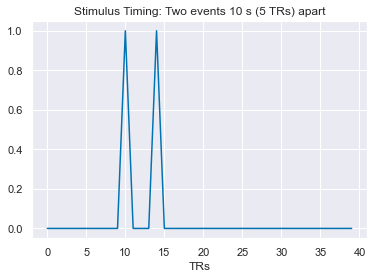

In [17]:
#Plot the design
plt.plot(stim_B)
plt.title('Stimulus Timing: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

In [18]:
# Create the expected neural response
signal_func_B = sim.convolve_hrf(stimfunction=stim_B,
                                   tr_duration=2,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

Text(0.5, 0, 'TRs')

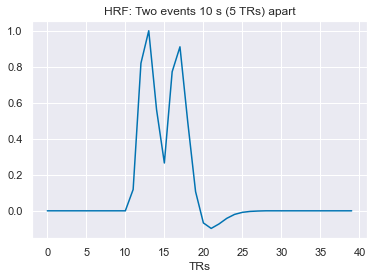

In [19]:
# Plot it
plt.plot(signal_func_B)
plt.title('HRF: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

Note the difference in the plots for the block and the two event signals. When stimuli are presented in blocks, the HRF sustains itself for the duration of the block. For the two event stimuli, presented far apart, the hemodynamic signal increases and falls after the first event and then recovers after the second stimuli is shown, before finally going down to baseline. 

**Self-study:** Play around with these parameters and look at what happens to the expected neural response under a variety of timing choices

**1.3.2 Time shift the VDC labels**  
You will note that it takes approximately 4-6s for the BOLD response to peak after an event. Hence the brain's activity does not reflect what is occuring in the world currently, but rather what occurred in the recent past. To account for the hemodynamic lag, we can shift the timecourse of labels such that they correspond in time with the future brain response they produce. First let's plot this timecourse.

Text(0.5, 0, 'Time in secs')

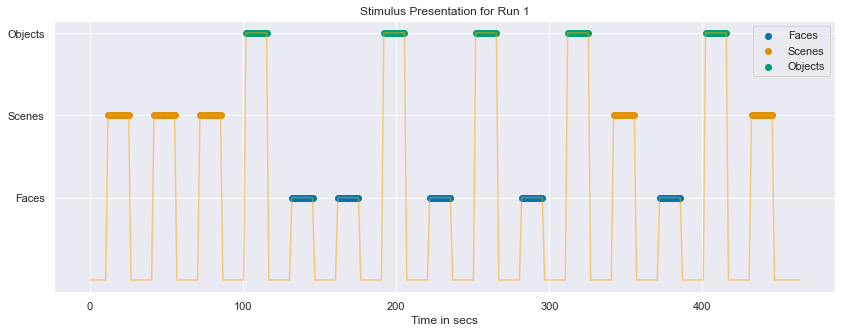

In [20]:
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)
time_vals = stim_label_allruns[2, 0:150]
labels = stim_label_allruns[0, 0:150]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time in secs')


We need to incorporate this time-shift when we extract the BOLD signal for classification (so that the labels apply to the correct brain images). One way to accomplish this is to shift the labels and extract the BOLD signal for the non-zero labels. Given that one TR = 1.5 s and the typical hemodynamic lag is 4-5 s, we will shift the labels forwards by 3 TRs.

In [21]:
# Shift the data a certain amount
print('Amount of time shift: %0.1f' % vdc_hrf_lag) # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(vdc_hrf_lag / vdc_TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

print(np.nonzero(stim_label_TR)[0].shape)
print(np.nonzero(stim_label_TR_shifted)[0].shape)

Amount of time shift: 4.5
(450,)
(450,)


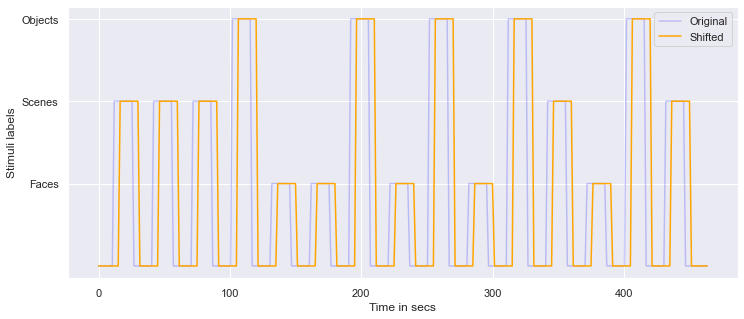

In [22]:
# Add the boxcar to the plot

f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='blue',alpha=0.2)
ax.plot(tr_time, stim_label_TR_shifted[0:310], c='orange')

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

plt.legend(['Original', 'Shifted'])

Note how the shifted boxcar is not plotted automatically into the cell above. This is because plotting goes into the figure after plt.figure() was called and will keep writing there (automatically sets 'hold on' if you are familiar with MATLAB) until you call a new plt.figure().

### 1.4 Load the fMRI data<a id="load_fmri"></a>

As in the exercise from 02-data-handling, we will load in, mask, and z-score the fMRI data. This time we are going to load in all participants, so this may take a while.

In [23]:
print('available ROIs: ', vdc_all_ROIs)

available ROIs:  ['FFA', 'PPA']


In [24]:
roi_name = 'FFA'

# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Check the dimensionality of the data
print('voxel by TR matrix - shape: ', epi_mask_data_all[vdc_all_ROIs.index(roi_name)].shape)
print('label list - shape: ', stim_label_TR_shifted.shape)

Loaded FFA mask
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
voxel by TR matrix - shape:  (5519, 930)
label list - shape:  (930,)


## 2. Classification<a id="classification"></a>

We will now build a very basic classifier to categorize our data. 

In the example of email, spam mail has certain characteristics (or features) such as: sent from an unknown sender; sells products; asks for money deposits. These features are converted into mathematical vectors in a language feature space and computer programs are trained on these feature vectors,  _from known examples of relevant and spam emails_, to categorize emails as either relevant or spam. 

For brain activity measured by fMRI, the voxel signals serve as the features. If we were showing pictures of faces, scenes, and objects, and collecting fMRI data while the subject was viewing the pictures, we know what picture was shown at each time-point. The stimulus type at each timepoint serves as the stimulus label. The signal from voxels at each timepoint correspond to the features of that picture. From this known set of stimulus labels and features, we can train a classifier to distinguish between pictures of faces, scenes, and objects.

Once the classifier training is accomplished, we still do not know how this classifier will perform when it has to make a prediction on fMRI signals for an image that it was not trained on (e.g. a new picture of a face). To determine whether the classifier can predict the stimulus label of an _unseen stimulus_, we test it on an _unseen dataset_ and determine the prediction accuracy. If the classifier makes predictions above chance (random guessing will lead to a 33.33% accuracy for 3 categories), the classifier has read out from the brain the category of the stimulus.

We will try the SVM classifier in this exercise.  
<div class="alert alert-block alert-info">
Each classifier has a number of parameters that can be changed to affect the sensitivity of the classification (called hyper-parameters). For now, we will hard code these parameters. We will cover more principled ways to do classification in a future notebook. 
</div>

### 2.1 Reshape data <a id="reshape"></a>

First, we extract the time points for which we have stimulus labels (only Faces, Places, and Objects). That is, we drop the time-points from the BOLD signal that refer to the fixation periods.

In [25]:
# Extract bold data for non-zero labels
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index]
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points
roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data)

# What is the dimensionality of the data? We need the first dim to be the same
print('The %s has the dimensionality of: %d time points by %d voxels' % (roi_name, bold_data.shape[0], bold_data.shape[1]))

The FFA has the dimensionality of: 450 time points by 5519 voxels


### 2.2 Leave-One-Run-Out (LORO) training and testing  <a id="model_training"></a>

We have the vdc dataset to train our classifier. From where do we get an unseen dataset to test the accuracy of the classifier? We use LORO. A typical fMRI experiment has multiple runs, wherein the same categories are shown in all runs. One trick we can use is to create an unseen dataset is to not train the classifier on all runs, let's say we Leave One Run Out from the training set. This left-out run is now our unseen dataset -- the classifier was never trained on these data. We can use this dataset to test the accuracy of the classifier.

Furthermore, we can loop through the runs, leaving out a run each time (also known as folding), and test multiple times. Let's say we have 3 runs: 1,2,3. Then, we can establish the sequence of training and testing, giving us 3 independent tests of the classifier accuracy, as shown in the table below. This process of splitting the available data to train and test classifiers is called cross-validation. You can also find more help on this topic [here](https://scikit-learn.org/stable/modules/cross_validation.html).

| Fold | Train | Test |
| --- | --- | --- |
|1 |  run1, run2 | run3 |
|2 |  run2, run3 | run1 |
|3 |  run3, run1 | run2 |
  

**LORO is a good first step for cross-validation, but there are also other ways to achieve cross-validation.**

There are other ways you could do this that we will cover in the course. Sometimes it is an even better approach to leave a participant out in the analysis, so that way you can test whether your classifier transfers across people. Other times it is not appropriate to do your training and testing across runs. For instance, imagine you are studying how people learn two categories of information over an fMRI session: in this case the runs are not interchangeable since in the early runs they won't have learned much compared to the later runs. In such cases we need to *carefully* split our data within a run into training and test.

#### 2.2.1. Manually create a left-out run.

In [26]:
# Get run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1
print(len(stim_label_allruns[5,:]))

# Select a run
holdout_run_ids = 0

# Make an index list with one run left out.
train_runs = run_ids != holdout_run_ids

450


Text(0.5, 0, 'index')

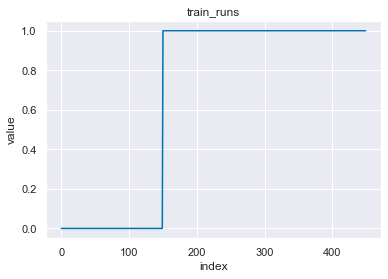

In [27]:
# Let's look at what the runs that will be used for training (value=1) and runs that will be used for testing (value=0).
plt.plot(train_runs)
plt.title('train_runs')
plt.ylabel('value')
plt.xlabel('index')

**2.2.2 Normalization**

Normalization is an important step in classification. Normalization puts feature values in a similar range and reduces the variance across features and prevents classifiers from being biased towards features with large values.


In [28]:
print(bold_data.shape)
print(run_ids.shape)

(450, 5519)
(450,)


In [31]:
def normalize_new(bold_data_, run_ids):
    """normalized the data within each run
    
    Parameters
    --------------
    bold_data_: np.array, n_stimuli x n_voxels
    run_ids: np.array or a list
    
    Return
    --------------
    normalized_data
    """
    scaler = StandardScaler()
    data = []
    print(bold_data_.shape)
    print(run_ids.shape)
    for r in range(vdc_n_runs):
        data.append(scaler.fit_transform(bold_data_[run_ids == r, :]))
    normalized_data = np.vstack(data)
    return normalized_data

In [32]:
bold_data_normalized = normalize_new(bold_data, run_ids)

(450, 5519)
(450,)


### 2.3. Classifiers

We can use a variety of classifier algorithms for our analysis. They are easily accessed by calling scikit-learn libraries. In the example below, we use a linear [support vector machine (SVM)](https://scikit-learn.org/stable/modules/svm.html). It is one of the most commonly used classifiers in cognitive neuroscience as it is robust to low number of training samples and outliers in the data.

You can also explore a variety of classifiers [here](http://scikit-learn.org/stable/supervised_learning.html)

In [33]:
# Split the training set and test set ... 
X_train = bold_data_normalized[train_runs,]
y_train = labels[train_runs]
X_test = bold_data_normalized[np.logical_not(train_runs),]
y_test = labels[np.logical_not(train_runs)]

#### 2.3.1. Build a classifier and test on the held out run.

The `X_train` data was created by excluding one run. We use this to train a classifier and then test it on `X_test`, the dataset that was created from the held-out run.

In [35]:
# Create a classifier model for the training set 
model = LinearSVC(C=1)

# Fit the model
model.fit(X_train, y_train)

# Compute your evaluation on the test set
score = model.score(X_test, y_test)
print('Accuracy = %s' % score)

Accuracy = 0.88


#### 2.3.2. Build a classifier by training and testing on multiple folds.

We use scikit learn libraries to automate the task of creating multiple folds. The `PredefinedSplit` method does this automatically.

<div class="alert alert-block alert-warning">
<strong> The test dataset must always be independent of the train dataset.</strong>
<br>
There are <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection">multiple methods</a> to splitting training and test data. No matter which method is adopted, you should always make sure that the train and test datasets are independent. It's best to exercise caution and make sure any folding method that you use is working the way you want it to. You could do this be getting the row indices of the training and test datasets and making sure that they have no overlap and belong to unique runs. There are some special considerations in fMRI data because of the hemodynamic lag and other slow frequencies in the data.
</div>


As an example, if you do not separate the training and test dataset, you will get inflated accuracies (this is like taking a quiz after you have already been shown the answers). We will cover more of this aspect in future notebooks. Here's an example of re-using the same data for training and test and how it (artificially) inflates performance accuracy. ***NEVER*** do this.

In [36]:
"""double dipping"""

# Data normalizer 
scaler = StandardScaler()

# Classifier 
model = LinearSVC() 

X_train = scaler.fit_transform(bold_data)

# Fit a SVM
model.fit(X_train, labels)

# Calculate the accuracy for the training set which was used to fit the SVM classifier
score = model.score(X_train, labels)
print('Accuracy = %s' % score)

Accuracy = 1.0


Now we show how to split the dataset into training and testing in the correct way.

sklearn can handle the train-test split with [PredefinedSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html). This approach is particularly useful for LORO or when leaving a participant out.

In [37]:
# loop over all runs 
scores = []

# split data according to run ids 
ps = PredefinedSplit(run_ids)

# classifier 
model = LinearSVC() 
for train_index, test_index in ps.split():
    X_train, X_test = bold_data_normalized[train_index], bold_data_normalized[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # fit an svm
    model.fit(X_train, y_train)
    
    # calculate the accuracy for the hold out run
    score = model.score(X_test, y_test)
    scores.append(score)
    
print('Accuracy across folds:', scores)

Accuracy across folds: [0.88, 0.8933333333333333, 0.8466666666666667]


**2.3.3 Classifier Performance**  
To determine how good is the accuracy of a classifier, we can compare it to random guessing. In the VDC dataset, we have 3 equally represented sets of stimuli, and thus random guessing will result in being correct 1/3 of the time.

### 2.4 Perform the analysis on multiple  participants <a id="across_ppts"></a>

The next step is to run a classifier on a group of subjects. We will now create the condition variable, stim_label_TR, for all subjects and then use it to pull out the relevant participant data and then feed it into a classifier.

Before you run this command, make sure you save your notebook. You will be loading in a lot of data and so it might run into memory issues and crash your job. If you do have issues, change how many cores/memory you are using when you launch this notebook.

**Exercise 2:**<a id="ex2"></a> Convert the classifier code above into a function called `decode` with the inputs of data, labels, and run_labels.

In [40]:
# Put code here. The function should output models and scores
def decode(data, labels, run_labels):
    scores = []
    models = []
    ps = PredefinedSplit(run_labels)

    # classifier
    model = LinearSVC()
    for train_index, test_index in ps.split():
        X_train, X_test = data[train_index], data[test_index]
        Y_train, Y_test = labels[train_index], labels[test_index]

        # fit an svm
        model.fit(X_train, Y_train)

        # calculate the accuracy for the hold-out run
        score = model.score(X_test, Y_test)
        models.append(model)
        scores.append(score)

    return((models, scores))

Run the function on this participant

In [41]:
# Run the function 
models, scores = decode(bold_data_normalized, labels, run_ids)
print('Decoding accuracy across the 3 folds: ', scores)

Decoding accuracy across the 3 folds:  [0.88, 0.8933333333333333, 0.8466666666666667]


**Exercise 3:** <a id="ex3"></a> What is the average SVM accuracy for sub-01, sub-02 and sub-03?

In [43]:
# Insert code here
np.mean(scores)

0.8733333333333334

## 3. Modular vs. Distributed Processing <a id="mod"></a>

The discovery of the Fusiform Face Area (FFA; Kanwisher, McDermott, and Chun, 1997; see also McCarthy, Puce, Gore, & Allison, 1997) was ground breaking for the field. The mean activity signal for face stimuli was larger than the mean for houses and objects. Thus, the FFA was preferential to faces, and by extension, it was inferred that all other cognitive processing must also be localized in brain regions yet to be discovered. 

The local nature of processing was challenged by another study (Haxby et al., 2001). Instead of looking at the mean activity of a set of voxels, this study examined the _pattern of activity_ of a set of voxels. Thus, if the mean activity was similar for two conditions, but the pattern of activity across a set of voxels was different across the two conditions, we can discriminate between the two conditions. Using this technique, it was shown that faces are not represented just in the FFA alone, but are distributed across a variety of brain regions. This led to the distributed view of face processing.

In this section, you will perform a decoding analysis in the FFA and the parahippocampal place area (PPA) using the VDC dataset. To recap, the FFA was shown as a face processing region and the PPA as a scene processing region. Specifically, you will analyze the patterns of activity in these ROIs in the following ways: 

>1. Can we discriminate scenes vs. objects in the FFA?  
      The FFA was shown to be a preferred region for face processing. If we can decode scenes vs. objects in this region, it implies that there is discriminable information for these two categories in the FFA. Thus, the FFA would not just represent faces, but scenes and/or objects too. Also, scenes would not be exclusively represented in the PPA. 
           
>2. Can we discriminate faces vs. objects in the PPA?  
      The PPA was shown to be a preferred region for scene processing. If we can decode faces vs. objects in this region, it implies that there is discriminable information for these two categories in the PPA. Thus, faces would not only be represented in the FFA. Also, the PPA would not just represent scenes, but faces and/or objects too.
      

### 3.1. Prepare the data for loading <a id="prep"></a>

Get the data ready for analysis of one participant by organizing it by ROI

In [55]:
# choose a subject
sub = 'sub-01';

# Convert the shift from secs to TRs
shift_size = int(vdc_hrf_lag / vdc_TR) 

# Load subject labels
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir,sub) 

# Load the fMRI data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Convert the timing into TR indexes
TRs_run = int(epi_mask_data_all[0].shape[1] / vdc_n_runs)
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)
# Select and reshape FFA data 
bold_data_FFA, labels = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('FFA')])

# Select and reshape PPA data 
bold_data_PPA, _ = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('PPA')])

# Specify the classifiers that will be used
svc = LinearSVC()

# load run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1 

Loaded labels for sub-01
Loaded FFA mask
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii


### 3.2 FFA decoding <a id="mod_dist_ffa"></a>

**Exercise 4:**<a id="ex4"></a> Decode Objects vs. Scenes from the FFA and report mean LORO test accuracy.

In [48]:
# Put code here
models_ffa, scores_ffa = decode(bold_data_FFA, labels, run_ids)
mean_acc_ffa = np.mean(scores_ffa)
mean_acc_ffa

0.3933333333333333

**A:**
0.39

### 3.2 PPA decoding <a id="mod_dist_ppa"></a>

**Exercise 5:**<a id="ex5"></a> Decode Objects vs. Faces from the PPA and report mean LORO test accuracy.

In [49]:
# Put code here
models_ppa, scores_ppa = decode(bold_data_PPA, labels, run_ids)
mean_acc_ppa = np.mean(scores_ppa)
mean_acc_ppa

0.42

**Exercise 6:**<a id="ex6"></a>  What can you infer about the processing of faces, objects, and scenes in the FFA and PPA? Say a few words about what this example can tell you about modular vs. distributed processing in the brain.

**A:**
The model is better at decoding objects relative to faces in the PPA than in the FFA, suggesting that the PPA carries
a more coherent representation of objects than faces and is therefore able to discriminate them more effectively.
This example suggests that certain brain regions are indeed sensitive to more modularized representations of specific
categories of objects.

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

In [57]:
# Do these patterns persist when we scramble the labels?
labels_shuffle = labels
np.random.shuffle(labels_shuffle)

models_ffa_shuffle, scores_ffa_shuffle = decode(bold_data_FFA, labels_shuffle, run_ids)
mean_acc_ffa_shuffle = np.mean(scores_ffa_shuffle)

models_ppa_shuffle, scores_ppa_shuffle = decode(bold_data_PPA, labels_shuffle, run_ids)
mean_acc_ppa_shuffle = np.mean(scores_ppa_shuffle)

print(mean_acc_ffa_shuffle)
print(mean_acc_ppa_shuffle)

# Patterns of accuracy change and are not very different from each other when labels are scrambled!

0.3511111111111111
0.3333333333333333


## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 02/2018   
T. Meissner minor edits  
Q. Lu a lot of edits...   
M. Kumar added section introductions.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented feedback from cmhn-s19.  
S. Rhoads edited plots and comments to improve clarity.   
A.K. Sahoo made edits to comments.